### 1. Problem Undestanding
Here we will look at a Data Science challenge within the IMDB space. For our model fitting choose the f1-score metric.

### Import libraries & data 

In [300]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

%matplotlib inline

In [301]:
#Results of exploring for model we will provided in table model_search_result
model_search_result = pd.DataFrame(columns=['Model',
                                            'Preprocessing',
                                            'Vectorizer',
                                            'F1 train',
                                            'F1 test', ], )
model_search_result

,Model,Preprocessing,Vectorizer,F1 train,F1 test


In [302]:
# import & display data
data = pd.read_csv('data/IMDB_Dataset.csv')

### The Data
Our training set has 50K movie reviews for natural language processing.  This is a dataser for binary sentiment classification. 
For more dataset information, please go through the following link,
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [303]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Check statistics

In [304]:
data.count()

review       50000
sentiment    50000
dtype: int64

In [305]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [306]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


The Dataset contains invalid non-unique values. In the next step research we should drop all data repetitions

In [307]:
data[data.duplicated()].head()

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative


#### replace the categoric values from 'sentiment' to numeric

In [308]:
data['sentiment'] = data['sentiment'].replace({'positive' : 1, 'negative' : 0})

In [309]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### 2. Splitting data for train and test sets

In [310]:
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [311]:
print('Size of train set: ' + str(X_train.size) +
     '\nShare of positive samples in train set: ' + str(y_train[y_train==1].count()/y_train.size))
print('Size of test set: ' + str(X_test.size) +
     '\nShare of positive samples in test set: ' + str(y_test[y_test==1].count()/y_test.size))

Size of train set: 35000
Share of positive samples in train set: 0.5
Size of test set: 15000
Share of positive samples in test set: 0.5


#### Applying CountVectorizer for convert a collection of text documents to a matrix of token counts

In [312]:
# Instantiate the vectorizer
count_vectorizer = CountVectorizer()
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [313]:
# fit and transform on it the training features
count_vectorizer.fit(X_train)
X_train_features = count_vectorizer.transform(X_train)

#transform the test features to sparse matrix
X_test_features = count_vectorizer.transform(X_test)


#### Resulting the vocabulary dictionary 

In [314]:
list(count_vectorizer.vocabulary_.keys())[:20]

['if',
 'you',
 'want',
 'to',
 'see',
 'true',
 'thriller',
 'rent',
 'this',
 'it',
 'not',
 'from',
 'the',
 'director',
 'or',
 'screenwriter',
 'of',
 'scream',
 'doesn',
 'feature']

### 3. Classify

In [315]:
#definition constants
RANDOM_STATE = 11
MAX_ITER=4000
NUMBER_K_FOLD = 5
TARGET_METRIC = 'f1'

# definition common function


# calculate F1-score
def calculateF1Train(model):
    return f1_score(y_train, model.predict(X_train_features))

def calculateF1Test(model):
    return f1_score(y_test, model.predict(X_test_features))
    

# add data to result table
def addModelToResultTable(resultTable, model, preprocessing, vectorizer, ):
    modelItem = [model,
                 preprocessing, 
                 vectorizer,                                     
                 calculateF1Train(model), 
                 calculateF1Test(model)]
    if any([modelItem == list(row[1][:]) for row in resultTable.iterrows()]):
        return(resultTable)
    resultTable.loc[resultTable.shape[0] + 1] = modelItem
    return(resultTable)
    
# plot F1-score
def plotF1Curve():
    plt.title("A F1 score curve")
    plt.plot([1.0, 0.046], model_search_result['F1 train'], label ='F1_train')
    plt.plot([1.0, 0.046], model_search_result['F1 test'], label='F1_test')
    plt.xlabel("C")
    plt.ylabel("f1")
    plt.legend()


    

#### Explore data with different regularization values


In [316]:
#function for choose region for cross validation C
def foundAppropriateRegionC(C_param_range):
    sepal_acc_table = pd.DataFrame(columns = ['C_parameter','F1_train', 'F1_test'])
    sepal_acc_table['C_parameter'] = C_param_range
    j = 0
    for i in C_param_range:
         # Apply logistic regression model to training data
            lr = LogisticRegression(C = i,random_state = RANDOM_STATE, max_iter=MAX_ITER)
            lr.fit(X_train_features, y_train)  
            # Saving F1 score in table
            sepal_acc_table.iloc[j,1] = calculateF1Train(lr)
            sepal_acc_table.iloc[j,2] = calculateF1Test(lr)
            j += 1
    print(sepal_acc_table)
    plt.title("A F1 score curve")
    plt.plot(sepal_acc_table['C_parameter'], sepal_acc_table['F1_train'], label ='F1_train')
    plt.plot(sepal_acc_table['C_parameter'], sepal_acc_table['F1_test'], label='F1_test')
    plt.xlabel("C")
    plt.ylabel("f1")
    plt.legend()




##### Line plot of F1 score  vs hyperparameter  C (Inverse of regularization strength)

   C_parameter  F1_train   F1_test
0        0.001  0.872818  0.866398
1        0.010    0.9224  0.892467
2        0.100  0.970523  0.899435
3        1.000  0.997486  0.891023
4       10.000         1  0.884025
5      100.000         1  0.878889


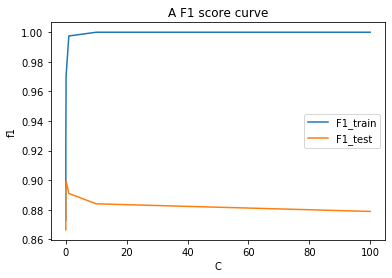

In [317]:
# start with C = [0.001,0.01,0.1,1,10,100]

foundAppropriateRegionC([0.001,0.01,0.1,1,10,100])

   C_parameter  F1_train   F1_test
0     0.010000    0.9224  0.892467
1     0.019307  0.936043  0.895719
2     0.037276  0.950235  0.899668
3     0.071969  0.963968  0.899768
4     0.138950  0.976485  0.898285
5     0.268270  0.986806  0.896625
6     0.517947  0.993457  0.893109
7     1.000000  0.997486  0.891023


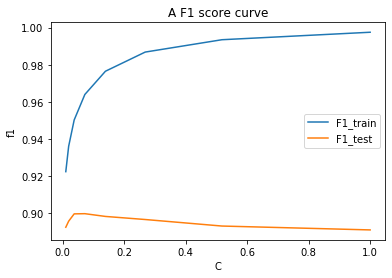

In [318]:
# Chose the smaller range for C = np.logspace(-2, 0, 8)
foundAppropriateRegionC(np.logspace(-2, 0, 8))



Choose this region for cross validation: np.logspace(-2, 0, 8)

##### Grid search cross validation


In [319]:
hyperparams_log_reg = {
    'C': np.logspace(-2, 0, 8), 
}

logreg_model_cross_valid=LogisticRegression(random_state=RANDOM_STATE, max_iter=MAX_ITER)
logreg_cv = GridSearchCV(logreg_model_cross_valid, 
                         hyperparams_log_reg, scoring =TARGET_METRIC, 
                         cv=NUMBER_K_FOLD, 
                         return_train_score=True )

logreg_cv.fit(X_train_features, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=4000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=11, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.01      , 0.01930698, 0.03727594, 0.07196857, 0.13894955,
       0.26826958, 0.51794747, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)

#### Results Cross Validation

##### The best value F1 score for cross validation

In [320]:
logreg_cv.best_score_

0.8923749869574473

##### The best estimator for cross validation

In [321]:
logreg_cv.best_estimator_

LogisticRegression(C=0.07196856730011521, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Result of Cross validation with 5 folds

In [322]:

result_cv = pd.DataFrame(columns = ['C_param', 'F1-score'], index = range(0,5))
for splitN in range(5):
    result_cv['F1-score'][splitN] = logreg_cv.cv_results_['split'+str(splitN)+'_test_score'].max()
    result_cv['C_param'][splitN] = logreg_cv.cv_results_['params'][np.argmax(logreg_cv.cv_results_['split'+str(splitN)+'_test_score'])]["C"]
result_cv

,C_param,F1-score
0,0.0372759,0.890687
1,0.0372759,0.886674
2,0.0719686,0.89562
3,0.0372759,0.893822
4,0.0719686,0.898391


### Choose the model after CV


In [323]:
baseline_model=LogisticRegression(C=logreg_cv.best_estimator_.C, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [324]:
baseline_model.fit(X_train_features, y_train)

LogisticRegression(C=0.07196856730011521, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### Add model to the result table

In [325]:
model_search_result = addModelToResultTable(model_search_result, baseline_model, 'None', count_vectorizer )
model_search_result

,Model,Preprocessing,Vectorizer,F1 train,F1 test
1,"LogisticRegression(C=0.07196856730011521, clas...",None,"CountVectorizer(analyzer='word', binary=False,...",0.963968,0.899768
